# visualize surprisal development


In [1]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT = Path("/Users/jliu/workspace/RAG/")
fig_path = ROOT / "fig"
surprisal_path = ROOT / "results" / "surprisal"
freq_path = ROOT / "datasets/freq/EleutherAI/pythia-410m"

In [4]:
T = t.TypeVar("T")

def d_stats(x):
    """Descriptive stats for an array of values."""
    stats = {
        "mean": np.mean(x),
        "median": np.median(x),
        "min": np.min(x),
        "max": np.max(x),
        "stdev": np.std(x, ddof=1),
        "first": np.percentile(x, 25),
        "third": np.percentile(x, 75),
    }
    return stats


def bin_stats(x, N):
    """Divide the array x into N bins and compute stats for each."""
    # Sort the array
    x_sorted = np.sort(x)
    # Calculate the number of elements in each bin
    n = len(x_sorted) // N
    bins = [x_sorted[i : i + n] for i in range(0, len(x_sorted), n)]
    # Ensure we use all elements (important if len(x) is not perfectly divisible by N)
    if len(x_sorted) % N:
        bins[-2] = np.concatenate((bins[-2], bins[-1]))
        bins.pop()
    # Compute stats for each bin using get_stats
    stats_list = [d_stats(bin) for bin in bins]
    # Create DataFrame from the list of stats dictionaries
    df = pd.DataFrame(stats_list)
    idx_lst = []
    idx = 0
    for word_bin in bins:
        idx_lst.extend([idx]*len(word_bin))
        idx+=1
    return df, idx_lst

def load_file(file_path: Path) -> pd.DataFrame:
    # Load the data
    data = pd.read_csv(file_path)
    # Create a new DataFrame for the result
    result = data[["target_word"]]
    # Then process numeric columns
    for col in data.columns:
        if col.isdigit():
            # Convert column name to log scale
            log_value = np.log10(float(col) + 1e-10)
            # Only keep columns with log value > 3.5
            if log_value > 3.5:
                # Use the log value as the new column name
                result[f"{log_value:.4f}"] = data[col]
    return result

def load_group_data(cdi_path):
    """load group path """
    # load freq file
    cdi_freq = pd.read_csv(cdi_path)
    cdi_sorted = cdi_freq.sort_values(by="freq_m")
    df, idx_lst = bin_stats(cdi_sorted["freq_m"], 6)
    cdi_sorted["bin_nb"] = idx_lst
    return cdi_sorted,df

def group_word(data,group_data,stat_df)->dict:
    """Group data into different bins."""
    data_grouped = group_data.groupby("bin_nb")
    group_dict = {}
    for bin_idx,data_group in data_grouped:
        median_freq = f"{stat_df["median"].tolist()[bin_idx]:.2f}"
        df_group = data[data["target_word"].isin(data_group["word"])]
        # remove the word column
        df_group = df_group.drop(columns=["target_word"])
        group_dict[median_freq] = df_group.mean()
    df = pd.DataFrame(group_dict)
    df = df.reset_index().rename(columns={'index': 'log_step'})
    return df

In [ ]:
# cocncatenate longtail

cdi_path = freq_path/"cdi_childes.csv"
eval_set = "cdi_childes"

model_lst = ["70m","410m"]
neuron_lst = [10,50,500]
vec_lst = ["base","mean","longtail"]

stat_frame = pd.DataFrame()
# loop ablation conditions
for model in model_lst:
    for vec in vec_lst:
        if vec == "base":
            file_path = surprisal_path/vec/eval_set/"EleutherAI"/f"pythia-{model}-deduped.csv"
            data = load_file(file_path)
            # group data
            stat = group_word(data,group_data,stat_df)
            for header,col_val in {"vec":vec,"neuron":0,"model":model, "ablation":"base"}.items():
                stat[header]=col_val
            stat_frame = pd.concat([stat_frame,stat])

        else:
            for ablation in ablation_lst:
                for neuron in neuron_lst:
                    file_path = surprisal_path/vec/ablation/eval_set/"EleutherAI"/f"pythia-{model}-deduped_{neuron}.csv"
                    if file_path.is_file():
                        data = load_file(file_path)
                        # group data
                        stat = group_word(data,group_data,stat_df)
                        for header,col_val in {"vec":vec,"neuron":neuron,"model":model, "ablation":ablation}.items():
                            stat[header]=col_val
                        stat_frame = pd.concat([stat_frame,stat])
                    else:
                        print(file_path)



In [10]:
# load group file
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
eval_set = "merged"

def get_stat(eval_set,cdi_path):
    ablation_lst = ["mean","zero","random"]

    
    group_data,stat_df = load_group_data(cdi_path)

    model_lst = ["70m","410m"]
    neuron_lst = [10,50,500]
    vec_lst = ["base","mean","longtail"]

    stat_frame = pd.DataFrame()
    # loop ablation conditions
    for model in model_lst:
        for vec in vec_lst:
            if vec == "base":
                file_path = surprisal_path/vec/eval_set/"EleutherAI"/f"pythia-{model}-deduped.csv"
                data = load_file(file_path)
                # group data
                stat = group_word(data,group_data,stat_df)
                for header,col_val in {"vec":vec,"neuron":0,"model":model, "ablation":"base"}.items():
                    stat[header]=col_val
                stat_frame = pd.concat([stat_frame,stat])

            else:
                for ablation in ablation_lst:
                    for neuron in neuron_lst:
                        file_path = surprisal_path/vec/ablation/eval_set/"EleutherAI"/f"pythia-{model}-deduped_{neuron}.csv"
                        if file_path.is_file():
                            data = load_file(file_path)
                            # group data
                            stat = group_word(data,group_data,stat_df)
                            for header,col_val in {"vec":vec,"neuron":neuron,"model":model, "ablation":ablation}.items():
                                stat[header]=col_val
                            stat_frame = pd.concat([stat_frame,stat])
                        else:
                            print(file_path)

    stat_frame.to_csv(surprisal_path/"stat.csv")




In [11]:
get_stat(eval_set,cdi_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jliu/workspace/RAG/results/surprisal/base/merged/EleutherAI/pythia-70m-deduped.csv'

In [8]:

def plot_ablation_development(csv_path: Path, output_dir: Path) -> None:
    """
    Create line plots showing the development of surprisal across log steps,
    similar to the example image provided.
    
    Args:
        csv_path: Path to the CSV file with neuron ablation data
        output_dir: Directory to save the output plots
    """
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Load the data
    df = pd.read_csv(csv_path)
    print(f"Loaded data with {len(df)} rows")
    
    # Get unique values for grouping
    models = df['model'].unique()
    vec_lst = ["mean","longtail"]
    ablations = [a for a in df['ablation'].unique() if a != 'base']  # Non-baseline ablations
    neurons = sorted([n for n in df['neuron'].unique()])
    
    # Set up colors for different neuron counts - matching example image
    neuron_colors = {
        0: '#1f77b4',    # blue for baseline
        10: '#ff7f0e',   # orange
        50: '#2ca02c',   # green
        #100: '#d62728',  # red
        500: '#9467bd'   # purple
    }
    
    # Identify numeric columns (metrics)
    metrics = ['2.12', '5.94', '15.59', '46.46', '205.35', '437.05']
    
    # Process each model and ablation type
    for vec in vec_lst:
        for model in models:
            for ablation in ablations:
                print(f"Processing model={model}, ablation={ablation}")
                # Create a new figure
                plt.figure(figsize=(10, 8))

                # Filter data for this model
                model_data = df[(df['model'] == model)&(df['vec'] == vec)]
                
                # Get baseline data (always include baseline for comparison)
                baseline_data = df[(df['model'] == model)&(df['ablation'] == 'base')]
                
                # Process baseline data
                if not baseline_data.empty:
                    # For each log_step, calculate mean across all metrics
                    baseline_grouped = baseline_data.groupby('log_step')
                    x_values = sorted(baseline_data['log_step'].unique())
                    y_values = []
                    
                    for log_step in x_values:
                        step_data = baseline_grouped.get_group(log_step)
                        mean_val = step_data[metrics].values.mean()
                        y_values.append(mean_val)
                    
                    # Plot baseline
                    plt.plot(x_values, y_values, color=neuron_colors[0], linewidth=2, label='base')
                
                # Process each neuron condition for this ablation
                for neuron in neurons:
                    if neuron == 0:  # Skip 0 neuron as it's part of baseline
                        continue
                    
                    # Filter data for this neuron and ablation combination
                    condition_data = model_data[(model_data['neuron'] == neuron) & 
                                            (model_data['ablation'] == ablation)]
                    
                    if condition_data.empty:
                        continue
                    
                    # For each log_step, calculate mean across all metrics
                    condition_grouped = condition_data.groupby('log_step')
                    x_values = sorted(condition_data['log_step'].unique())
                    y_values = []
                    
                    for log_step in x_values:
                        if log_step in condition_grouped.groups:
                            step_data = condition_grouped.get_group(log_step)
                            mean_val = step_data[metrics].values.mean()
                            y_values.append(mean_val)
                        else:
                            # Handle missing log_step values
                            y_values.append(np.nan)
                    
                    # Plot this neuron condition
                    plt.plot(x_values, y_values, color=neuron_colors.get(neuron, 'gray'), 
                            linewidth=2, label=str(neuron))
                
                # Style the plot to match the example
                plt.xlabel('Log step', fontsize=11)
                plt.ylabel('Mean surprisal', fontsize=11)
                plt.title(f'model={model}, intervention={ablation}', fontsize=13)
                plt.grid(alpha=0.2)
                
                # Create legend to match example
                handles, labels = plt.gca().get_legend_handles_labels()
                
                # If baseline is in the legend, make sure it comes first
                if 'base' in labels:
                    base_idx = labels.index('base')
                    # Move baseline to front
                    handles = [handles[base_idx]] + [h for i, h in enumerate(handles) if i != base_idx]
                    labels = [labels[base_idx]] + [l for i, l in enumerate(labels) if i != base_idx]
                
                plt.legend(handles, labels, loc='lower left')
                
                
                # Save the figure
                plt.tight_layout()
                plt.savefig(output_dir / f'all_{vec}_{model}_{ablation}.png', dpi=300, bbox_inches='tight')
                plt.close()


def ele_diff(list1, list2):
    """
    Calculate the element-wise difference between two lists of the same length.
    
    Args:
        list1: The first list
        list2: The second list
    
    Returns:
        A list containing the differences (list1[i] - list2[i]) for each position i
    """
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")
    
    differences = []
    for i in range(len(list1)):
        differences.append(list1[i] - list2[i])
    return differences


def plot_ablation_freq(csv_path: Path, output_dir: Path) -> None:
    """
    Create line plots showing the development of surprisal across log steps,
    similar to the example image provided.
    
    Args:
        csv_path: Path to the CSV file with neuron ablation data
        output_dir: Directory to save the output plots
    """
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Load the data
    df = pd.read_csv(csv_path)
    print(f"Loaded data with {len(df)} rows")
    
    # Get unique values for grouping
    models = df['model'].unique()
    vec_lst = ["mean","longtail"]
    ablations = [a for a in df['ablation'].unique() if a != 'base']  # Non-baseline ablations
    neurons = sorted([n for n in df['neuron'].unique()])
    
    # Set up colors for different neuron counts - matching example image
    neuron_colors = {
        0: '#1f77b4',    # blue for baseline
        10: '#ff7f0e',   # orange
        50: '#2ca02c',   # green
        #100: '#d62728',  # red
        500: '#9467bd'   # purple
    }
    
    # Identify numeric columns (metrics)
    metrics = ['2.12', '5.94', '15.59', '46.46', '205.35', '437.05']
    
    # Process each model and ablation type
    for vec in vec_lst:
        for model in models:
            for ablation in ablations:
                print(f"Processing model={model}, ablation={ablation}")
                # Create a new figure
                plt.figure(figsize=(10, 8))

                model_data = df[(df['model'] == model)&(df['vec'] == vec)]
                
                # Get baseline data (always include baseline for comparison)
                baseline_data = df[(df['model'] == model)&(df['ablation'] == 'base')]
                print(baseline_data.columns)

                # Process baseline data
                if not baseline_data.empty:
                    # For each log_step, calculate mean across all metrics
                    baseline_grouped = baseline_data.groupby('log_step')
                    x_values = sorted(baseline_data['log_step'].unique())
                    y_values = []
                    
                    for log_step in x_values:
                        step_data = baseline_grouped.get_group(log_step)
                        mean_val = step_data[metrics].values.mean()
                        y_values.append(mean_val)
                    
                    # Plot baseline
                    #plt.plot(x_values, y_values, color=neuron_colors[0], linewidth=2, label='base')
                
                # Process each neuron condition for this ablation
                for neuron in neurons:
                    if neuron == 0:  # Skip 0 neuron as it's part of baseline
                        continue
                    
                    # Filter data for this neuron and ablation combination
                    condition_data = model_data[(model_data['neuron'] == neuron) & 
                                            (model_data['ablation'] == ablation)]
                    
                    if condition_data.empty:
                        continue
                    
                    
                    # For each log_step, calculate mean across all metrics
                    condition_grouped = condition_data.groupby('log_step')
                    #x_values = sorted(condition_data['log_step'].unique())

                    
                    for metric in metrics:
                        # Plot this neuron condition
                        y_diff = ele_diff(condition_data[metric].to_list(),baseline_data[metric].to_list())
                        plt.plot(x_values, y_diff,linewidth=2, label=metric)
                        
                        # Style the plot to match the example
                    plt.xlabel('Log step', fontsize=11)
                    plt.ylabel('Mean surprisal', fontsize=11)

                
                    plt.title(f'model={model}, intervention={ablation},neuron={neuron}', fontsize=13)
                    plt.grid(alpha=0.2)
                
                    # Create legend to match example
                    handles, labels = plt.gca().get_legend_handles_labels()
                    
                    # If baseline is in the legend, make sure it comes first
                    if 'base' in labels:
                        base_idx = labels.index('base')
                        # Move baseline to front
                        handles = [handles[base_idx]] + [h for i, h in enumerate(handles) if i != base_idx]
                        labels = [labels[base_idx]] + [l for i, l in enumerate(labels) if i != base_idx]
                    
                    plt.legend(handles, labels, loc='lower left')
                    #plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='y = 0')
                    # Save the figure
                    plt.tight_layout()
                    plt.savefig(output_dir / f'freq_{vec}_{model}_{ablation}_{neuron}.png', dpi=300, bbox_inches='tight')
                    plt.close()



In [9]:

output_dir = fig_path / "mean_dev"
csv_path = surprisal_path/"stat.csv"
# Create bar plots
plot_ablation_development(csv_path = csv_path, output_dir=output_dir)


Loaded data with 3640 rows
Processing model=70m, ablation=mean
Processing model=70m, ablation=zero
Processing model=70m, ablation=random
Processing model=410m, ablation=mean
Processing model=410m, ablation=zero
Processing model=410m, ablation=random
Processing model=70m, ablation=mean
Processing model=70m, ablation=zero
Processing model=70m, ablation=random
Processing model=410m, ablation=mean
Processing model=410m, ablation=zero
Processing model=410m, ablation=random


In [18]:
cdi_path = freq_path/"cdi_childes.csv"
group_data,stat_df = load_group_data(cdi_path)
eval_set = "longtail_words"

def get_stat(eval_set):
    ablation_lst = ["mean","zero","random"]

    model_lst = ["70m"]
    neuron_lst = [10,50,500]
    vec_lst = ["base","mean","longtail"]

    stat_frame = pd.DataFrame()
    # loop ablation conditions
    for model in model_lst:
        for vec in vec_lst:
            if vec == "base":
                file_path = surprisal_path/vec/eval_set/"EleutherAI"/f"pythia-{model}-deduped.csv"
                data = load_file(file_path)
                stat_frame = pd.concat([stat_frame,data])

            else:
                for ablation in ablation_lst:
                    for neuron in neuron_lst:
                        file_path = surprisal_path/vec/ablation/eval_set/"EleutherAI"/f"pythia-{model}-deduped_{neuron}.csv"
                        if file_path.is_file():
                            data = load_file(file_path)
                            stat_frame = pd.concat([stat_frame,data])
                        else:
                            print(file_path)

    return stat_frame

In [19]:
stat_frame = get_stat(eval_set)

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_6534/294398224.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_6534/294398224.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_6534/294398224.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

/Users/jliu/workspace/RAG/results/surprisal/mean/random/longtail_words/EleutherAI/pythia-70m-deduped_10.csv
/Users/jliu/workspace/RAG/results/surprisal/mean/random/longtail_words/EleutherAI/pythia-70m-deduped_50.csv
/Users/jliu/workspace/RAG/results/surprisal/mean/random/longtail_words/EleutherAI/pythia-70m-deduped_500.csv
/Users/jliu/workspace/RAG/results/surprisal/longtail/random/longtail_words/EleutherAI/pythia-70m-deduped_10.csv
/Users/jliu/workspace/RAG/results/surprisal/longtail/random/longtail_words/EleutherAI/pythia-70m-deduped_50.csv
/Users/jliu/workspace/RAG/results/surprisal/longtail/random/longtail_words/EleutherAI/pythia-70m-deduped_500.csv


/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_6534/294398224.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_6534/294398224.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f"{log_value:.4f}"] = data[col]
/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_6534/294398224.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [23]:
output_dir = fig_path / "longtail/mean_dev"

csv_path = surprisal_path/"stat_longtail.csv"
stat_frame.to_csv(csv_path)
# Create bar plots
plot_ablation_development(csv_path = csv_path, output_dir=output_dir)

Loaded data with 11180 rows


KeyError: 'model'

In [20]:
stat_frame

,target_word,3.6021,3.6990,3.7782,3.8451,3.9031,3.9542,4.0000,4.0414,4.0792,...,5.1271,5.1303,5.1335,5.1367,5.1399,5.1430,5.1461,5.1492,5.1523,5.1553
0,selves,5.081853,5.416893,4.124481,5.220534,4.862697,5.096181,6.417839,5.226209,5.769827,...,6.213547,5.314106,6.148089,6.114464,5.198809,4.443929,4.843375,4.924430,5.555794,6.092495
1,selves,17.644665,18.861048,17.559488,17.878273,18.469198,18.526283,19.255491,19.397448,17.376797,...,17.518230,18.387201,18.358990,17.008142,16.828926,16.810110,16.976974,16.668314,17.255592,15.695961
2,selves,14.928635,12.061435,10.565018,10.374101,10.940964,9.913749,9.732368,8.407385,7.128606,...,8.868980,11.017687,9.682637,8.860136,9.185990,9.024972,8.837464,8.731384,8.797934,7.254818
3,mega,16.311314,15.832009,14.677512,14.177814,14.877748,14.358662,15.187715,15.574939,15.028000,...,18.276966,17.798519,16.199627,17.646471,17.193914,17.553915,16.560934,17.113174,17.571278,15.673454
4,mega,4.480710,5.664289,6.455317,5.371166,4.632257,5.908920,4.709406,7.789823,8.462381,...,7.428173,7.502834,7.651610,7.297141,7.253968,7.484074,5.976861,6.791261,7.664072,7.568632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,sequential,10.008779,9.910406,10.689094,9.528986,9.869879,10.767529,11.541224,11.122530,11.857928,...,15.398462,14.143032,13.438570,15.183613,15.002991,14.454885,15.818866,15.862360,16.185511,14.513931
856,sequential,15.780682,17.437595,16.608139,16.090855,16.860809,17.975807,18.003193,18.846928,18.393614,...,20.725424,20.061646,18.153223,17.644268,18.790319,18.355658,17.843464,18.749432,19.737968,19.517014
857,sequential,17.249266,16.266680,15.876972,16.683195,16.257427,16.662134,16.476358,17.618317,16.301893,...,16.725649,17.505480,15.737692,16.359528,16.702173,16.037361,15.780669,15.959530,16.519619,14.738835
858,sequential,15.896375,18.271229,17.637014,18.538010,18.623041,20.010315,20.857876,20.662243,21.248787,...,15.501699,15.824737,13.800708,13.727693,15.833467,14.081892,13.531441,14.575825,14.708428,14.567089


In [19]:
output_dir = fig_path / "freq_dev"
csv_path = surprisal_path/"stat.csv"
# Create bar plots
plot_ablation_freq(csv_path = csv_path, output_dir=output_dir)

Loaded data with 4060 rows
Processing model=70m, ablation=mean
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing model=70m, ablation=zero
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing model=70m, ablation=random
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing model=410m, ablation=mean
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing model=410m, ablation=zero
Index(['Unnamed: 0', 'log_step', '2.12', '5.94', '15.59', '46.46', '205.35',
       '437.05', 'vec', 'neuron', 'model', 'ablation'],
      dtype='object')
Processing mod

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

Finished loading base file


/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_26706/3418708400.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(surprisal_path / neuron_mode / word_set / model_family / model_size)


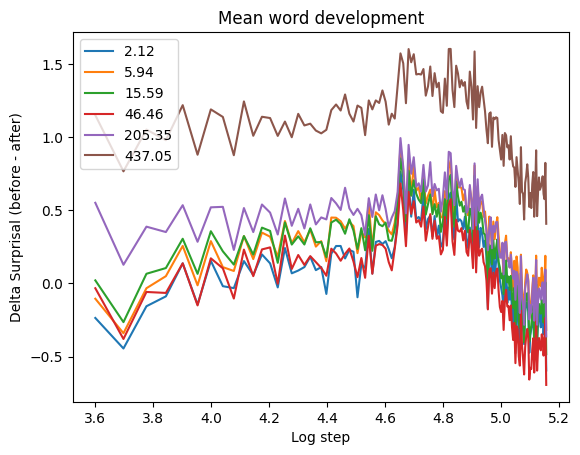

In [41]:
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
word_set = "cdi_childes"
model_family = "EleutherAI"
model_size = "pythia-410m-deduped"
data_base = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
group_data,stat_df = load_group_data(cdi_path)
data_base_dict = group_word(data_base,group_data,stat_df)
print("Finished loading base file")

data_exp = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_10.csv")
data_exp_dict = group_word(data_exp,group_data,stat_df)

df = compare_neuron_group(data_base_dict,data_exp_dict)

Finished loading base file


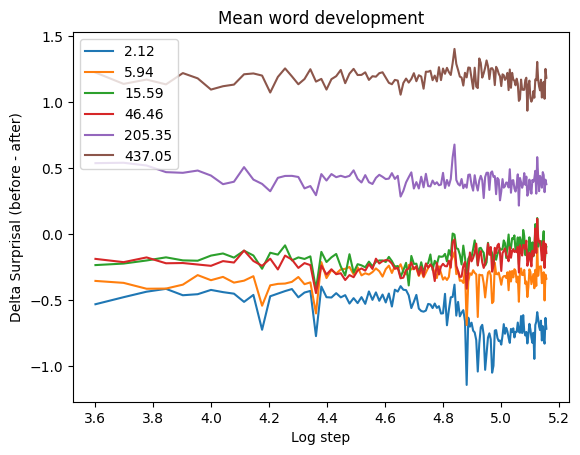

In [37]:
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
word_set = "cdi_childes"
model_family = "EleutherAI"
model_size = "pythia-70m-deduped"
data_base = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
group_data,stat_df = load_group_data(cdi_path)
data_base_dict = group_word(data_base,group_data,stat_df)

print("Finished loading base file")

data_exp = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_10.csv")
data_exp_dict = group_word(data_exp,group_data,stat_df)

df = compare_neuron_group(data_base_dict,data_exp_dict)

Finished loading base file


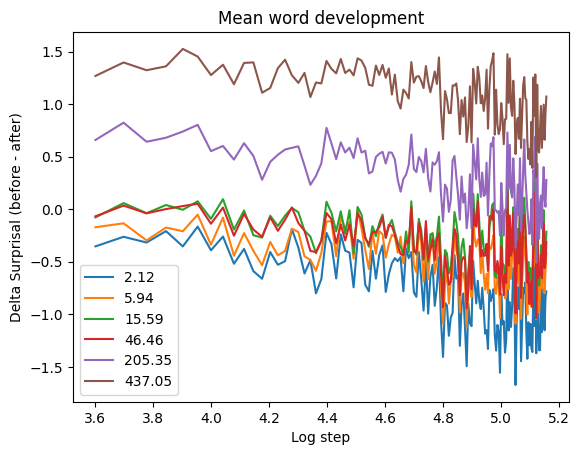

In [39]:
data_exp = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_500.csv")
data_exp_dict = group_word(data_exp,group_data,stat_df)

df = compare_neuron_group(data_base_dict,data_exp_dict)

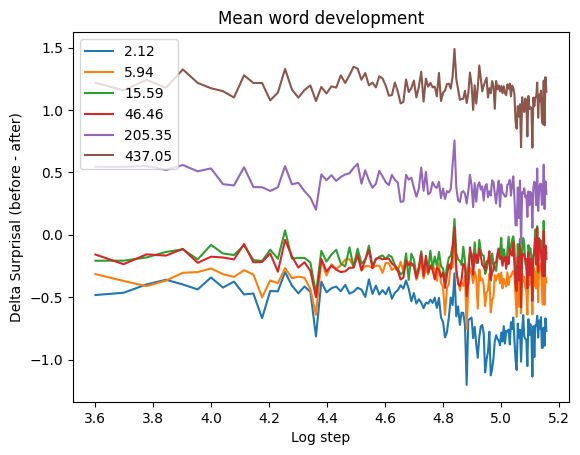

In [40]:
data_exp = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_100.csv")
data_exp_dict = group_word(data_exp,group_data,stat_df)

df = compare_neuron_group(data_base_dict,data_exp_dict)

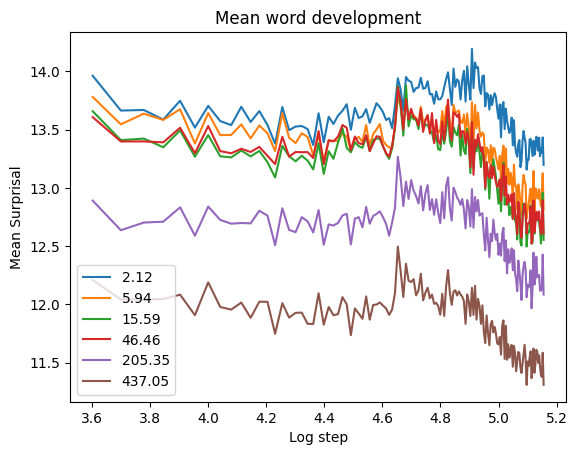

In [7]:
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
word_set = "cdi_childes"
model_family = "EleutherAI"
model_size = "pythia-70m-deduped"
data = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
group_data,stat_df = load_group_data(cdi_path)
data_dict = group_word(data,group_data,stat_df)
df = compare_neuron_mean(data_dict)

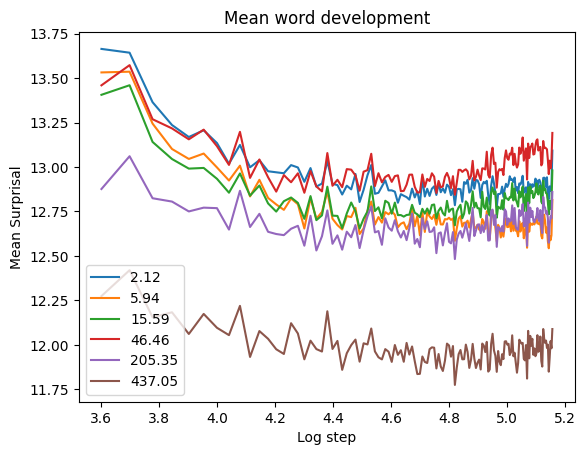

In [8]:
# load file as a dict
cdi_path = freq_path/"cdi_childes.csv"
word_set = "cdi_childes"
model_family = "EleutherAI"
model_size = "pythia-410m-deduped"
data = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
group_data,stat_df = load_group_data(cdi_path)
data_dict = group_word(data,group_data,stat_df)
df = compare_neuron_mean(data_dict)

In [28]:
df

,log_step,surprisal
0,3.602060,12.274673
1,3.698970,12.420142
2,3.778151,12.155556
3,3.845098,12.183611
4,3.903090,12.061696
...,...,...
135,5.143015,11.849906
136,5.146128,11.929979
137,5.149219,12.021145
138,5.152288,11.981333


/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_74522/3127851761.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(surprisal_path / neuron_mode / word_set / model_family / model_size)


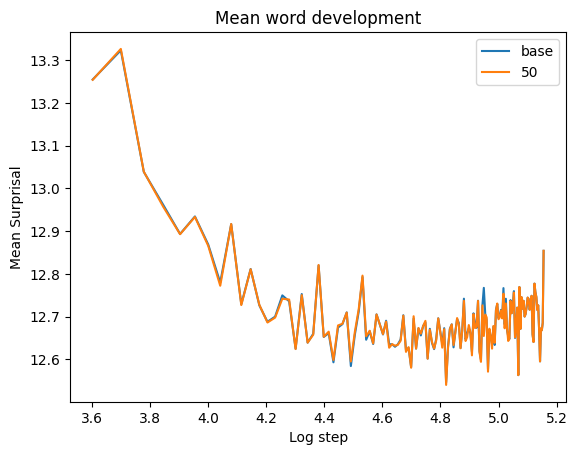

In [33]:
# load file as a dict
word_set = "ws-produce"
model_family = "EleutherAI"
model_size = "pythia-410m-deduped"

base = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
#neuron_10 = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_10.csv")
neuron_50 = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_50.csv")
#neuron_100 = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_100.csv")

data_dict = {"base":base,50:neuron_50}
compare_neuron_mean(data_dict)

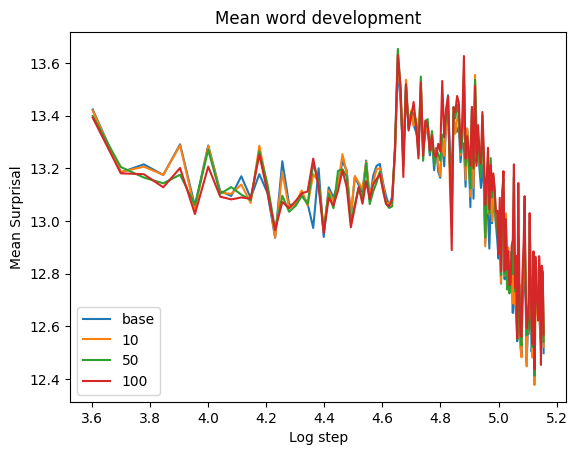

In [34]:
# load file as a dict
word_set = "ws-produce"
model_family = "EleutherAI"
model_size = "pythia-70m-deduped"

base = load_file(surprisal_path,"base",word_set,model_family,f"{model_size}.csv")
neuron_10 = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_10.csv")
neuron_50 = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_50.csv")
neuron_100 = load_file(surprisal_path,"zero",word_set,model_family,f"{model_size}_100.csv")

data_dict = {"base":base,10:neuron_10,50:neuron_50,100:neuron_100}
compare_neuron_mean(data_dict)